In [1]:
import numpy as np
import sklearn
import pandas as pd
from pandas import Series
import os
import datetime
from sklearn.decomposition import *
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
os.chdir('/Users/Clement Natta/Desktop/PFE')

In [3]:
data=pd.read_csv('RawData.csv', sep=",")

In [4]:
data.columns

Index(['Ntime', 'time', 'Close Price', 'Open Price', 'High Price', 'Low Price',
       'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5',
       'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index', 'Federal Fund Rate'],
      dtype='object')

In [5]:
df = pd.DataFrame(data['Volume'])
df.index = data['Ntime']

In [23]:
data1 = data.copy()
del data1['Ntime']
data1.drop(['time', 'Close Price'], axis=1, inplace=True)

In [24]:
data1.head()

,Open Price,High Price,Low Price,Volume,MACD,CCI,ATR,BOLL,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,Federal Fund Rate
0,1276.69,1285.31,1260.68,584629.0,-25.545595,-127.422349,24.63,1347.154231,1327.453482,1307.927,-33.09,1289.682,-75.12,-5.523408,-0.039542,-37722454.84,72.34,2.11
1,1285.82,1292.17,1261.51,527609.0,-27.571986,-115.864929,30.66,1342.391538,1321.174102,1300.298,-52.77,1277.592,-98.62,-7.250724,-0.060551,-52042778.81,71.99,1.95
2,1262.96,1271.48,1252.01,324759.0,-28.735319,-115.171527,19.47,1337.470769,1315.624188,1292.305,-59.07,1273.542,-88.03,-6.516252,-0.041755,-55561481.94,72.73,1.92
3,1262.90,1273.95,1240.68,526542.0,-30.164080,-111.302302,33.27,1331.857308,1309.594265,1285.743,-26.07,1268.328,-85.50,-6.740987,-0.049841,-53525518.26,72.71,1.99
4,1251.84,1274.17,1242.84,603411.0,-29.233405,-82.732708,31.33,1326.985000,1306.175764,1281.313,-6.30,1267.068,-69.13,-3.356020,-0.030884,-39091131.65,72.96,1.97


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from keras import losses
from keras.utils.np_utils import to_categorical
import keras

Using TensorFlow backend.


In [9]:
def price_returns(dataset):
    returns = list()
    returns.append(0)
    for i in range(1, len(dataset)):
        value = (1.0*dataset[i]/dataset[i - 1]) - 1
        returns.append(value)
    return Series(returns)

In [10]:
def timeseries_to_supervised(data, lag):
    df = pd.DataFrame(data)
    df_lag = pd.DataFrame(data.iloc[:,0])
    for i in range(0,df.shape[1]):
        columns = [df.iloc[:,i].shift(j) for j in range(1, lag+1)]
        columns.append(df_lag)
        df_lag = pd.concat(columns, axis=1)
        df_lag.fillna(0, inplace=True)
    return df_lag[lag:]

In [11]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [12]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [25]:
data2 = data1.copy()
data2.drop(['High Price', 'Low Price', 'Volume'], axis=1, inplace=True)
data2.head()
Ret = price_returns(data2['Open Price'])
data2['Returns'] = Ret
data2.head()
data3 = data2.copy()
data3.drop(['Open Price'], axis = 1, inplace = True)
data3.head()
cols = data3.columns.tolist()
cols = cols[-1:] + cols[:-1]
data3 = data3[cols]
data3.head()
data4 = data1.copy()
Ret = price_returns(data1['Open Price'])
data4['Returns'] = Ret
data4.drop(['Open Price'], axis = 1, inplace = True)
cols = data4.columns.tolist()
cols = cols[-1:] + cols[:-1]
data4 = data4[cols]

In [26]:
def run_index_scaled(timestep, repeats, n_batch, n_epochs, n_neurons, train_up, train_low, test_up, test_low):
    '''timestep, repeats, n_batch, n_epochs, n_neurons, train_up, train_low, test_up, test_low'''
    supervised = timeseries_to_supervised(data3, timestep)
    # split data into train and test-sets
    train, test = supervised.values[train_low:train_up], supervised.values[test_low:test_up]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    for i in range(repeats):
        scores, predictions, expected = fit_lstm_index_scaled(train_scaled, test_scaled, scaler, n_batch, n_epochs, n_neurons, timestep)
        plt.plot(scores['train'], color='blue', label = 'Train RMSE')
        plt.plot(scores['test'], color='orange', label = 'Test RMSE')
        print('%d) TrainScore=%f, TestScore=%f' % (i, scores['train'].iloc[-1], scores['test'].iloc[-1]))
    plt.savefig('epochs_diagnostic.png')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show() 
    return scores, predictions, expected

In [44]:
from keras import optimizers
from keras.callbacks import TensorBoard

def fit_lstm_index_scaled(scaled_train, scaled_test, scaler, batch_size, nb_epoch, neurons, timestep):
    X, y = scaled_train[:, 0:scaled_train.shape[1]-1], scaled_train[:, -1]
#   X = X.reshape(X.shape[0], scaled_train.shape[1]-1, 1)
    X = X.reshape(int(X.shape[0]), int(timestep), int((scaled_train.shape[1]-1)/timestep))
    # prepare model
    dropout = 0.3
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0005)
    model.compile(loss = 'mean_squared_error', optimizer = adam)
#   model.compile(loss = 'mean_absolute_percentage_error', optimizer = adam)
    print(model.summary())
    initial_weights = model.get_weights()
    print('Initial weights:\n', initial_weights)
    # fit model
    train_rmse, test_rmse = list(), list()
    #tb_callback = keras.callbacks.TensorBoard(log_dir='/Users/admin/Documents/RL_portf_optimisation', histogram_freq=2, write_graph=True)
    #tb_callback.set_model(model)
    #callbacks = []
    #callbacks.append(tb_callback)
    for i in range(nb_epoch-1):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        modtrain, _,_=evaluate_index_scaled(model, scaled_train, scaler, batch_size, timestep)
        train_rmse.append(modtrain)
        model.reset_states()
        # evaluate model on test data
        modtest, _,_=evaluate_index_scaled(model, scaled_test, scaler, batch_size, timestep)
        test_rmse.append(modtest)
        model.reset_states()
        
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    # evaluate model on train data
    modtrain, _,_=evaluate_index_scaled(model, scaled_train, scaler, batch_size, timestep)
    train_rmse.append(modtrain)
    model.reset_states()
    # evaluate model on test data
    modtest, predictions,expected=evaluate_index_scaled(model, scaled_test, scaler, batch_size, timestep)
    test_rmse.append(modtest)
    model.reset_states()
    scores = pd.DataFrame()
    scores['train'], scores['test'] = train_rmse, test_rmse
    return scores, predictions, expected

In [52]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate_index_scaled(model, scaled_data, scaler, batch_size, timestep):
    # separate
    X, y = scaled_data[:,0:scaled_data.shape[1]-1], scaled_data[:,-1]
    # reshape X.shape[0], timestep, scaled_train.shape[1]-1
    reshaped = X.reshape(int(X.shape[0]), int(timestep), int((scaled_data.shape[1]-1)/timestep))
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    expected = list()
    for i in range(len(output)):
        yhat = output[i,0]
        ytrue = y[i]
#        ytrue = y[i,0]
# invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        ytrue = invert_scale(scaler, X[i], ytrue)
        predictions.append(yhat)
#       expected.append(ytrue.astype(int))
        expected.append(ytrue)
        # report performance
    plt.plot(expected, color = 'blue', label = 'True values')
    plt.plot(predictions, color = 'orange', label = 'Predicted values')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    f_score = mean_squared_error(expected, predictions)
    return f_score, predictions, expected

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
def signal(y_pred):
    signal = list()
    for i in range(0,len(y_pred)):
        if(y_pred[i]>0):
            signal.append(1)
        else:
            signal.append(-1)
    return Series(signal)

In [55]:
def transaction_cost(sig):
    count = 0
    for i in range(1, len(sig)):
        if(sig[i]!=sig[i-1]):
            count +=1
    return count*0.0002

In [56]:
run_index_scaled.__doc__

'timestep, repeats, n_batch, n_epochs, n_neurons, train_up, train_low, test_up, test_low'

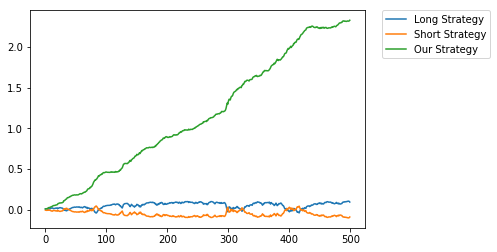

0.45711460731840681

In [59]:
s = signal(pred)
plt.plot((np.ones(len(s))*exp).cumsum(), label = 'Long Strategy')
plt.plot((-np.ones(len(s))*exp).cumsum(), label = 'Short Strategy')
plt.plot((s*exp).cumsum(), label = 'Our Strategy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
a=s*exp
((np.mean(a)-(transaction_cost(s)/len(s)))/(np.sqrt(len(s))*np.std(a)))*np.sqrt(250)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (10, 4)                   320       
_________________________________________________________________
dense_2 (Dense)              (10, 1)                   5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________
None
Initial weights:
 [array([[ -2.10977495e-01,  -3.50522667e-01,   2.71561742e-02,
         -3.81388068e-02,   2.34015048e-01,   3.47011566e-01,
         -8.88131559e-02,   1.23150647e-01,   2.48879850e-01,
          1.12456262e-01,  -9.74553525e-02,  -4.74199057e-02,
          3.85254323e-01,   2.36930132e-01,  -2.50065982e-01,
          2.45574176e-01],
       [  1.16294920e-02,   3.87516201e-01,  -1.44619435e-01,
         -9.03093815e-03,  -1.00461632e-01,  -2.96831131e-04,
          8.09291005e-02,   3.99680197e-01,   2.7946996

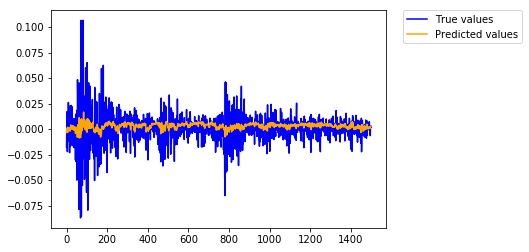

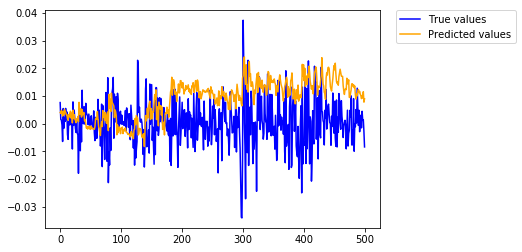

Epoch 1/1
 - 0s - loss: 0.0217


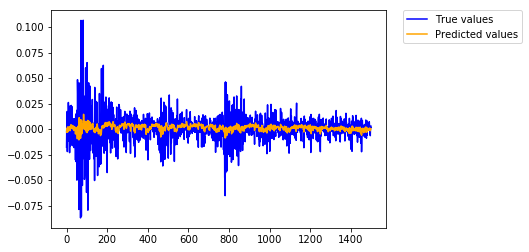

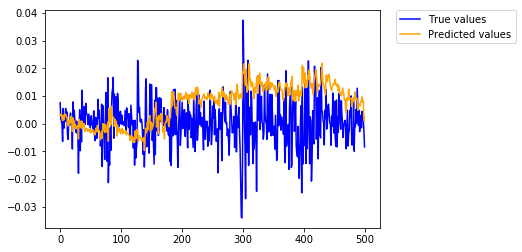

Epoch 1/1
 - 0s - loss: 0.0208


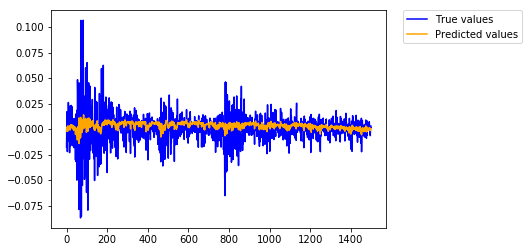

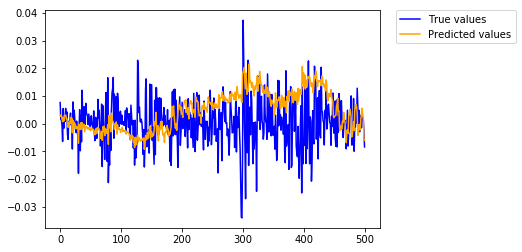

Epoch 1/1
 - 0s - loss: 0.0192


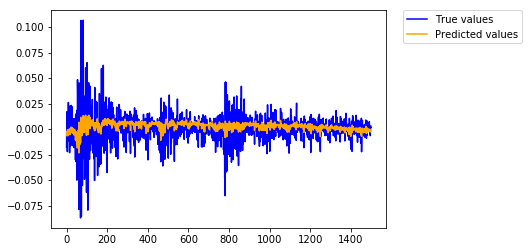

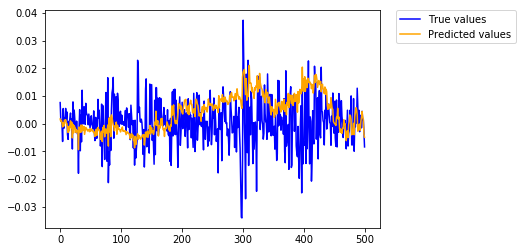

Epoch 1/1
 - 0s - loss: 0.0180


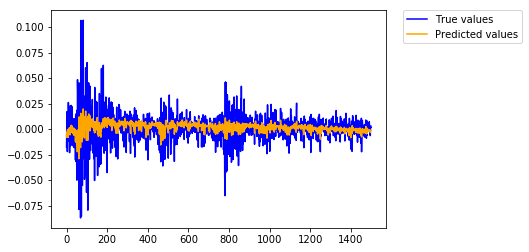

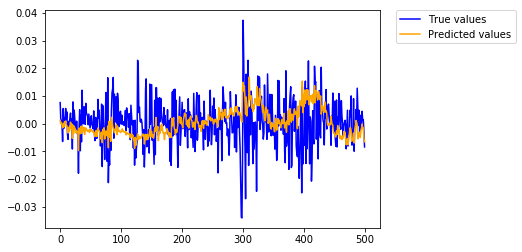

Epoch 1/1
 - 0s - loss: 0.0183


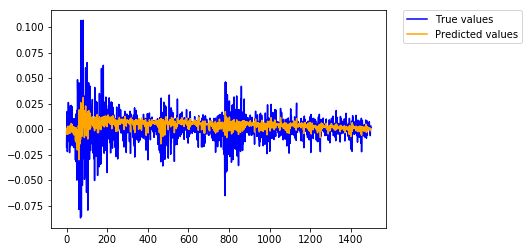

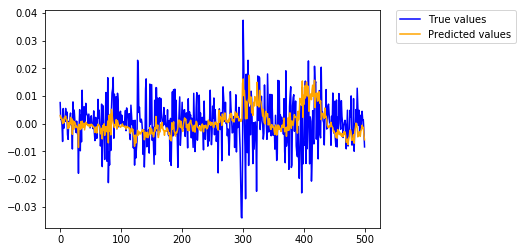

Epoch 1/1
 - 0s - loss: 0.0172


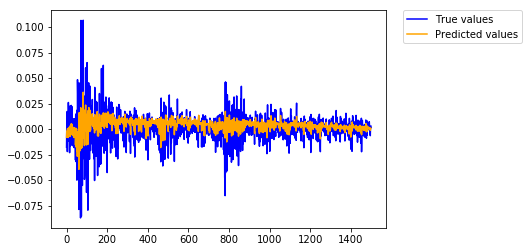

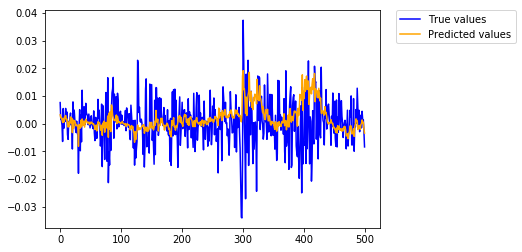

Epoch 1/1
 - 0s - loss: 0.0163


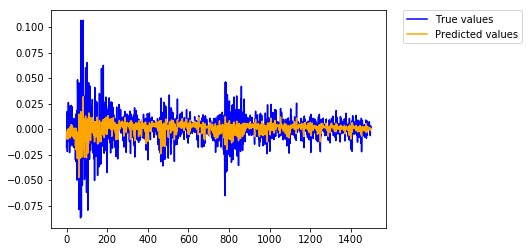

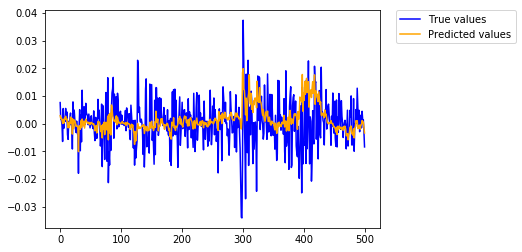

Epoch 1/1
 - 0s - loss: 0.0166


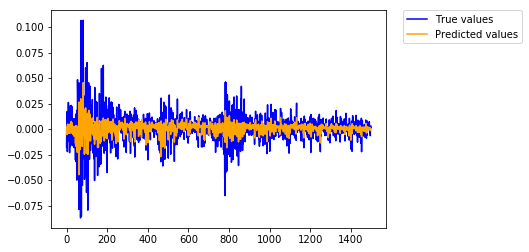

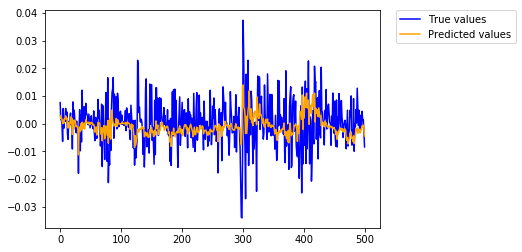

Epoch 1/1
 - 0s - loss: 0.0153


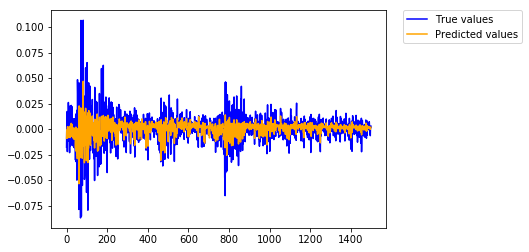

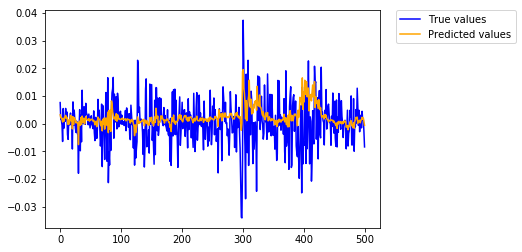

Epoch 1/1
 - 0s - loss: 0.0150


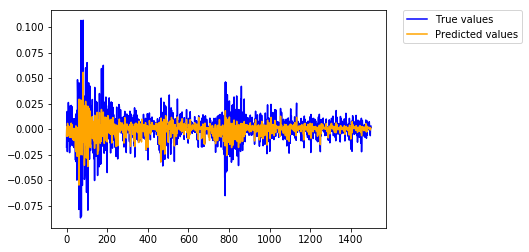

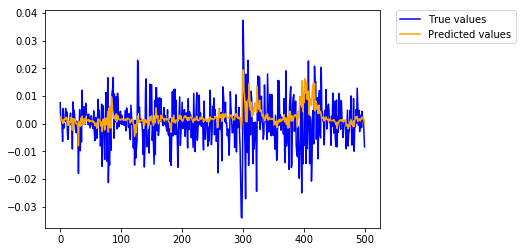

Epoch 1/1
 - 0s - loss: 0.0150


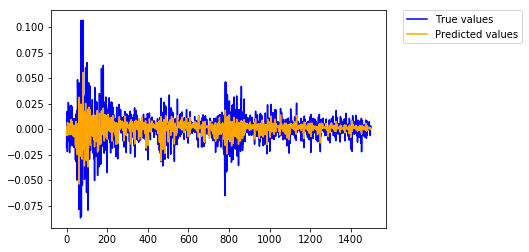

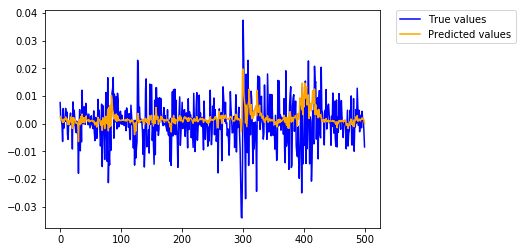

Epoch 1/1
 - 0s - loss: 0.0132


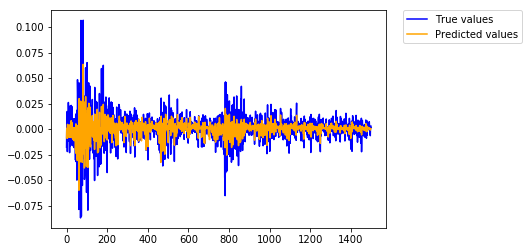

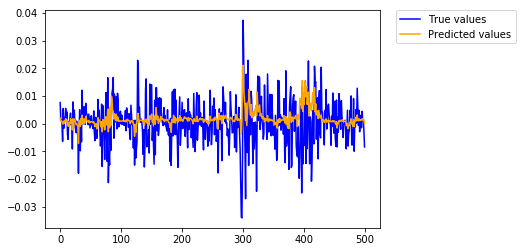

Epoch 1/1
 - 0s - loss: 0.0158


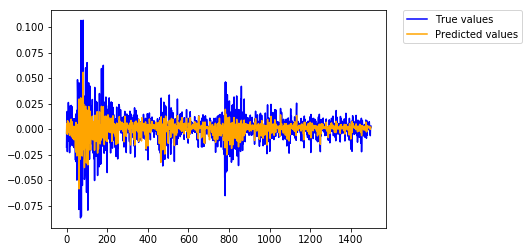

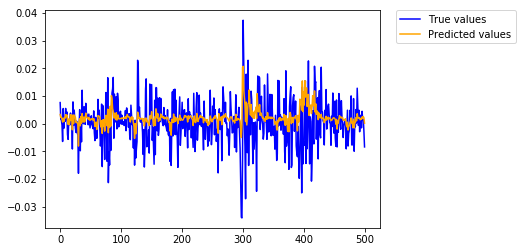

Epoch 1/1
 - 0s - loss: 0.0136


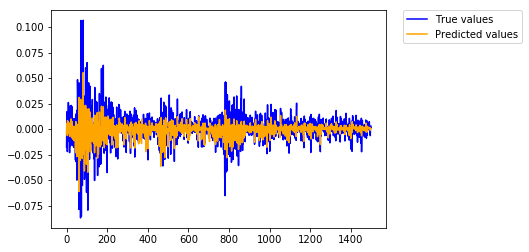

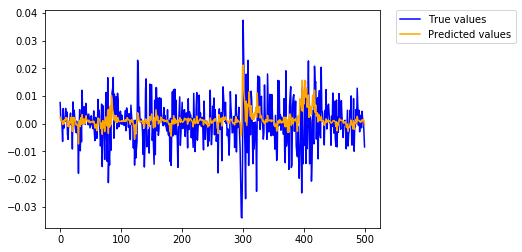

Epoch 1/1
 - 1s - loss: 0.0137


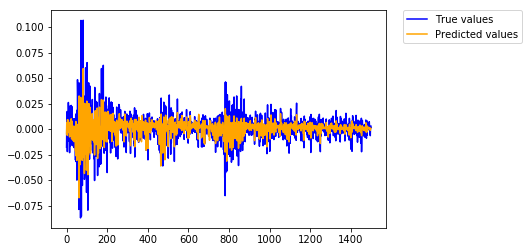

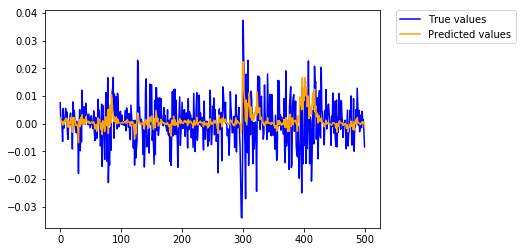

Epoch 1/1
 - 0s - loss: 0.0135


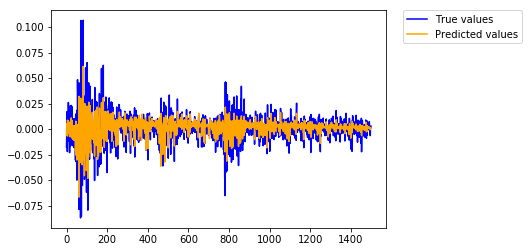

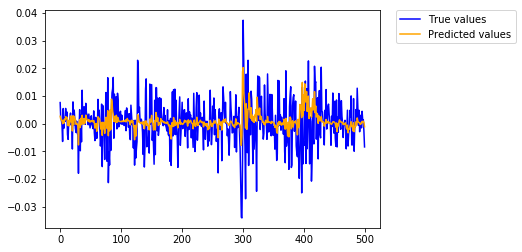

Epoch 1/1
 - 0s - loss: 0.0134


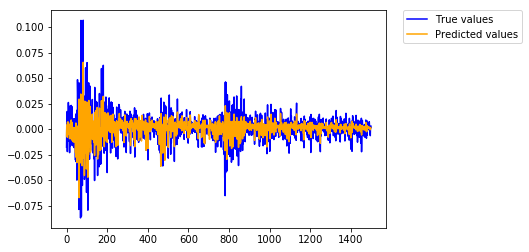

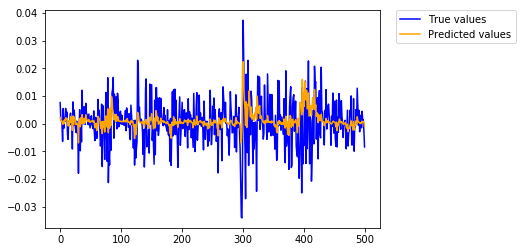

Epoch 1/1
 - 0s - loss: 0.0131


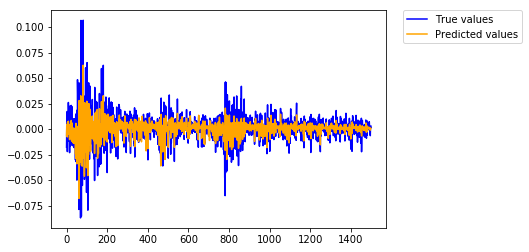

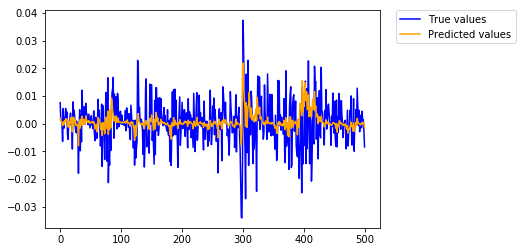

Epoch 1/1
 - 0s - loss: 0.0132


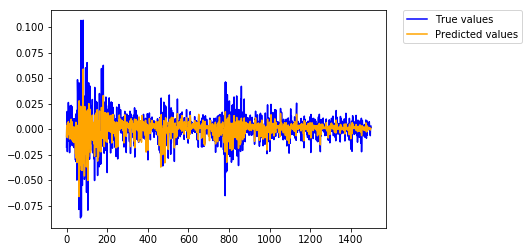

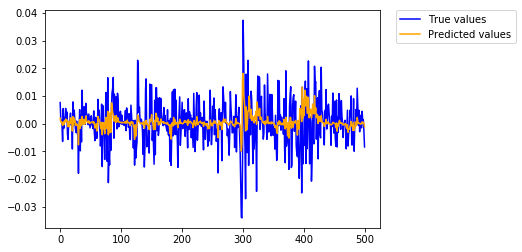

Epoch 1/1
 - 0s - loss: 0.0132


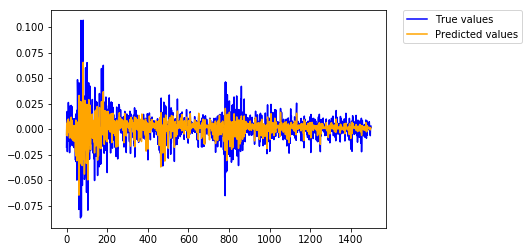

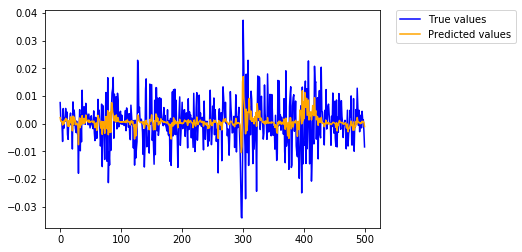

Epoch 1/1
 - 0s - loss: 0.0131


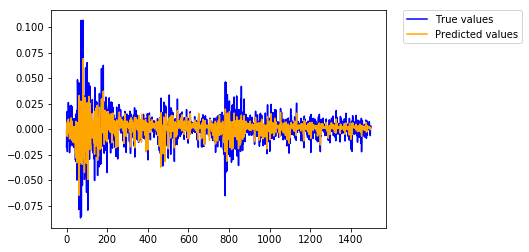

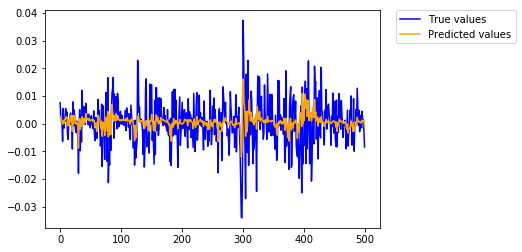

Epoch 1/1
 - 0s - loss: 0.0131


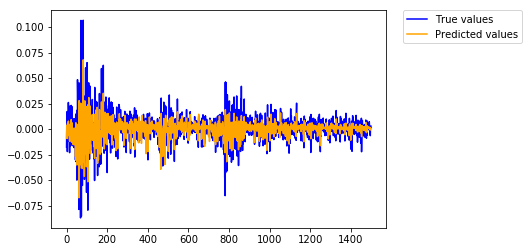

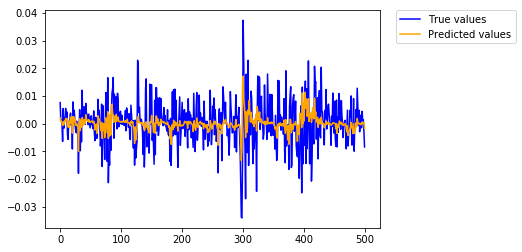

Epoch 1/1
 - 0s - loss: 0.0129


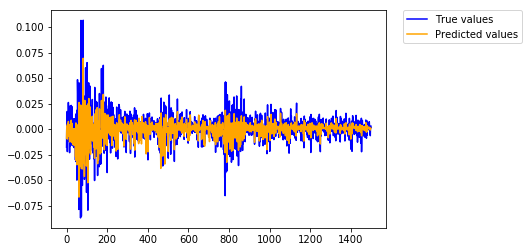

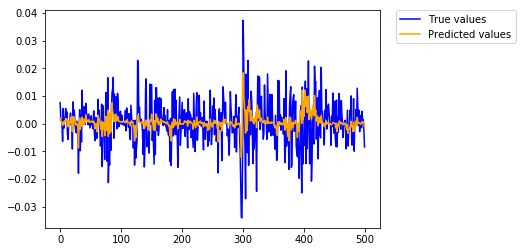

Epoch 1/1
 - 0s - loss: 0.0138


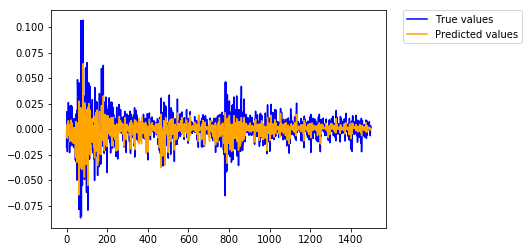

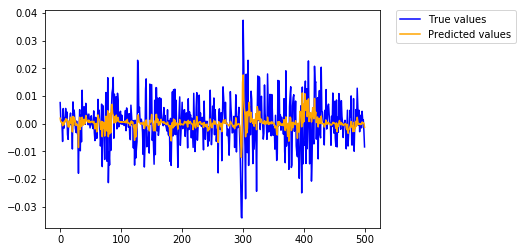

Epoch 1/1
 - 0s - loss: 0.0120


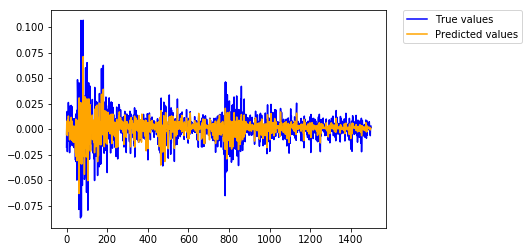

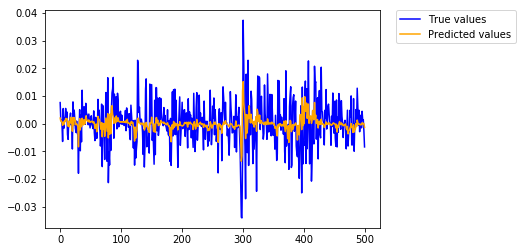

Epoch 1/1
 - 0s - loss: 0.0115


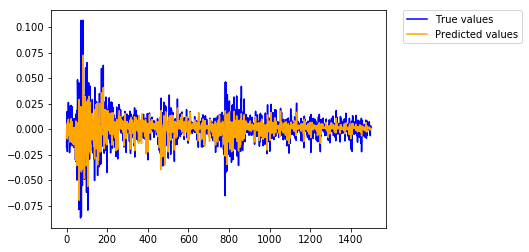

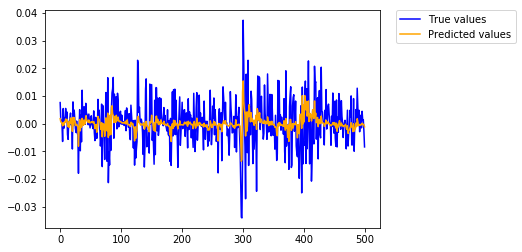

Epoch 1/1
 - 0s - loss: 0.0118


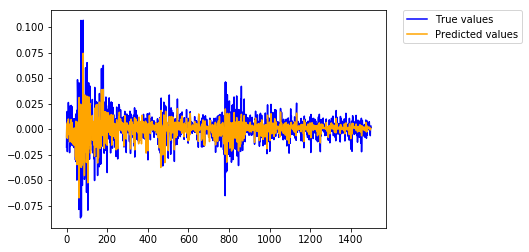

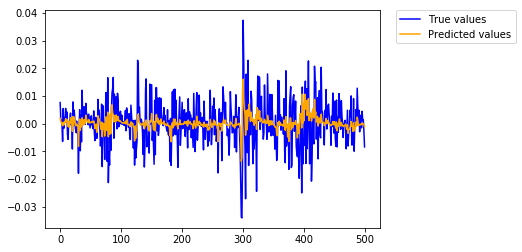

Epoch 1/1
 - 0s - loss: 0.0121


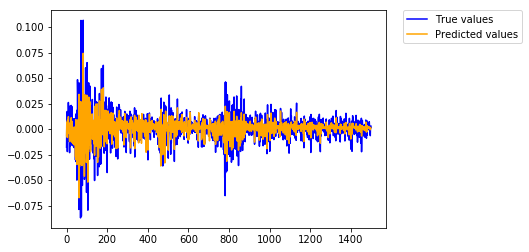

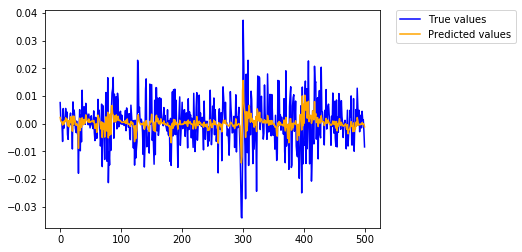

Epoch 1/1
 - 1s - loss: 0.0125


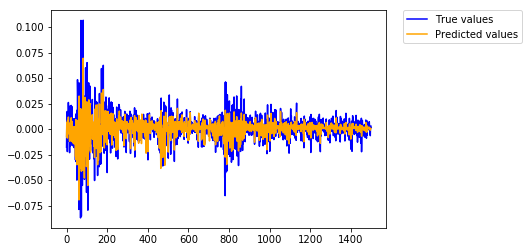

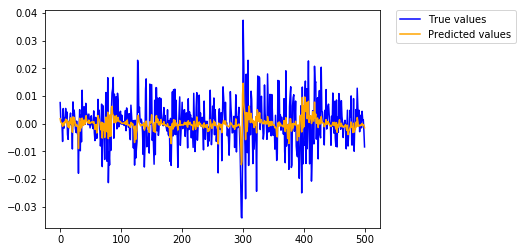

Epoch 1/1
 - 0s - loss: 0.0117


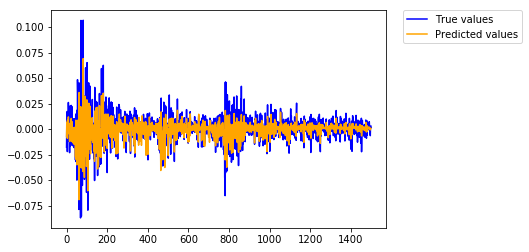

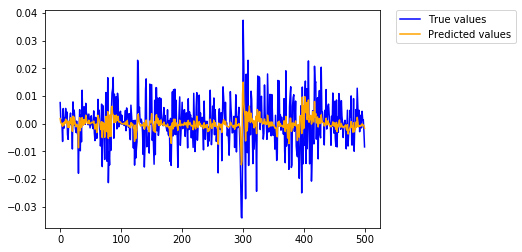

Epoch 1/1
 - 1s - loss: 0.0112


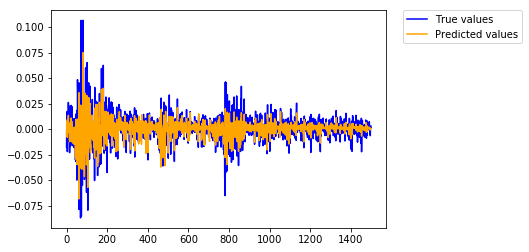

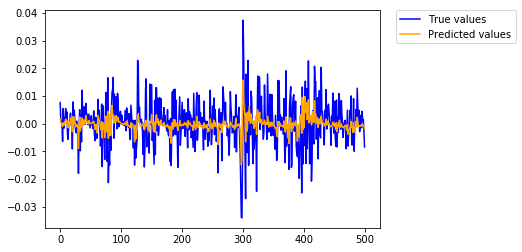

Epoch 1/1
 - 0s - loss: 0.0104


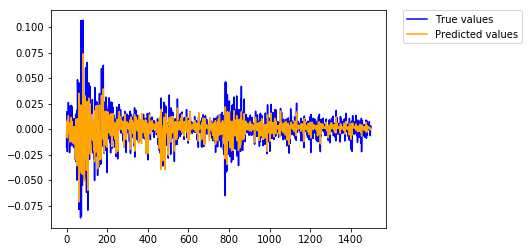

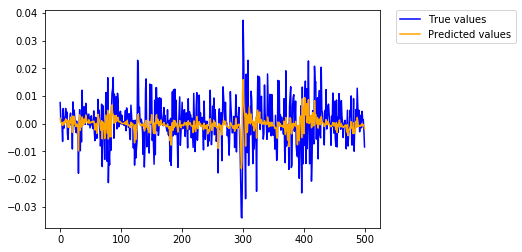

Epoch 1/1
 - 0s - loss: 0.0100


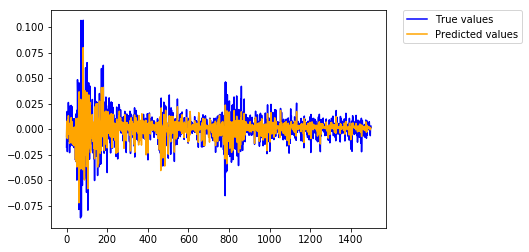

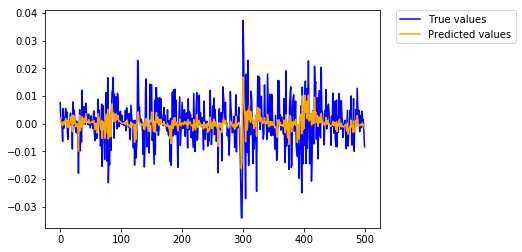

Epoch 1/1
 - 1s - loss: 0.0115


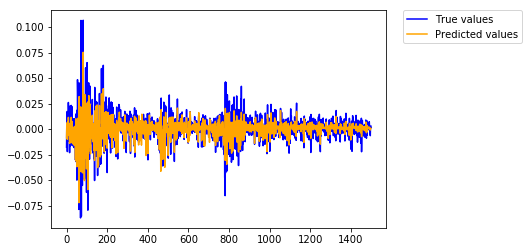

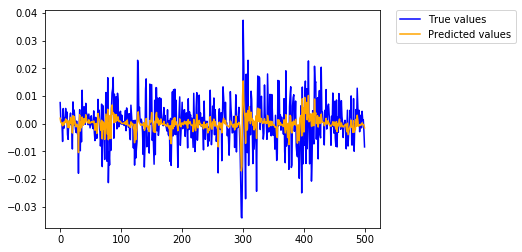

Epoch 1/1
 - 1s - loss: 0.0116


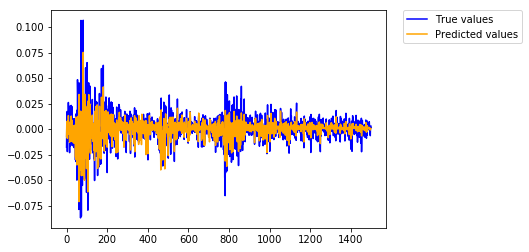

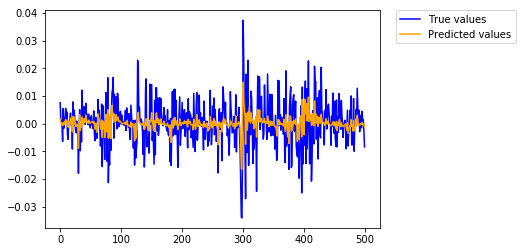

Epoch 1/1
 - 1s - loss: 0.0117


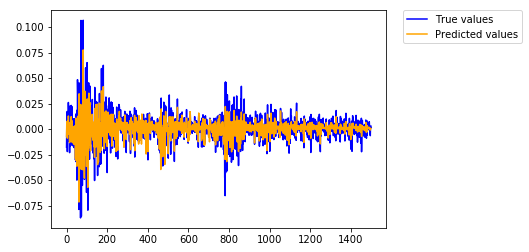

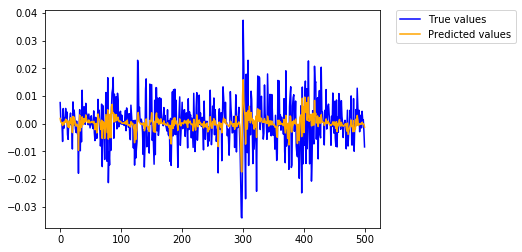

Epoch 1/1
 - 1s - loss: 0.0109


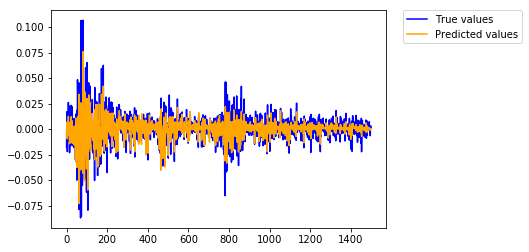

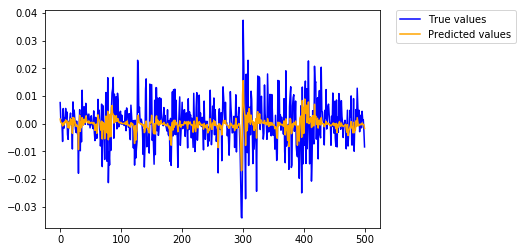

Epoch 1/1
 - 1s - loss: 0.0109


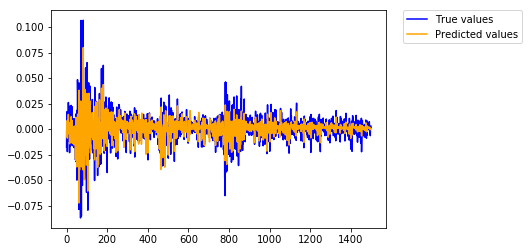

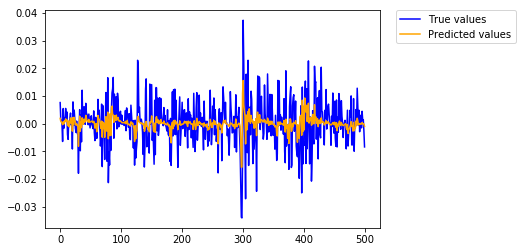

Epoch 1/1
 - 1s - loss: 0.0107


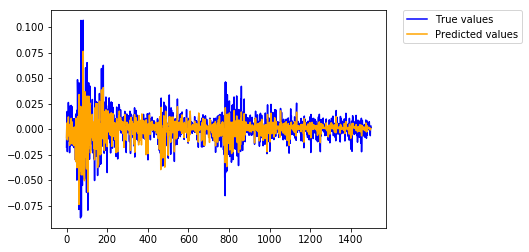

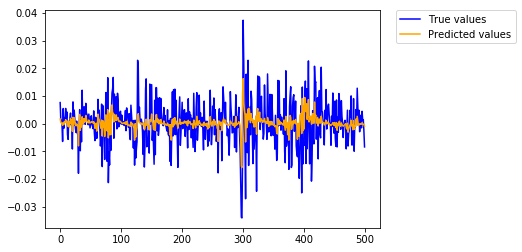

Epoch 1/1
 - 0s - loss: 0.0108


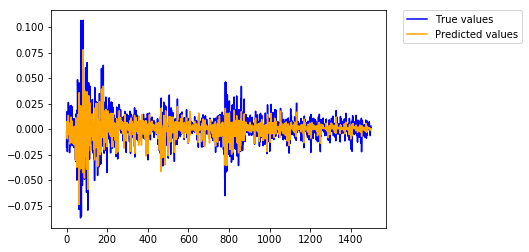

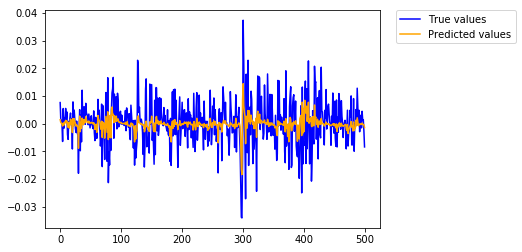

Epoch 1/1
 - 0s - loss: 0.0108


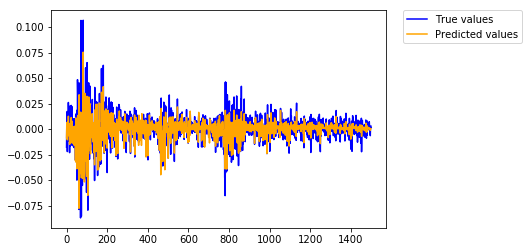

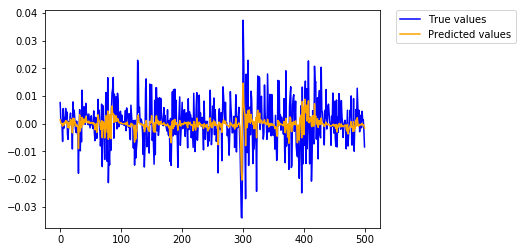

Epoch 1/1
 - 0s - loss: 0.0103


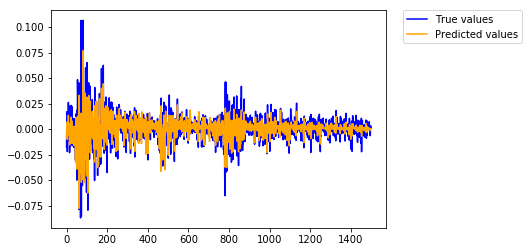

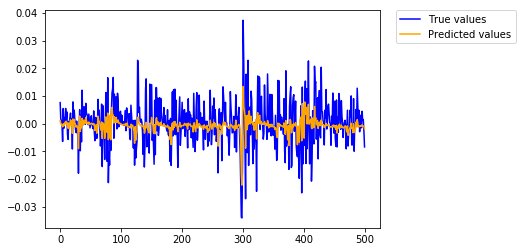

Epoch 1/1
 - 0s - loss: 0.0106


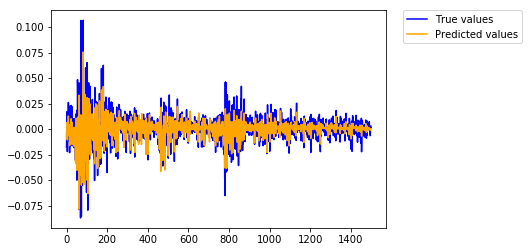

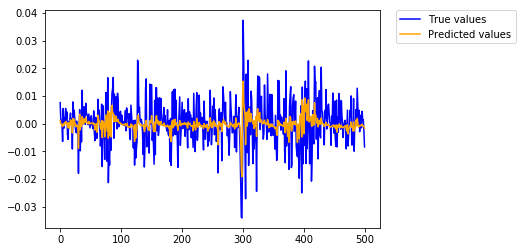

Epoch 1/1
 - 0s - loss: 0.0108


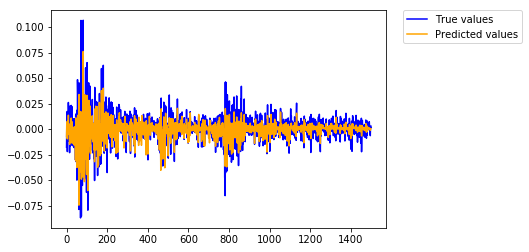

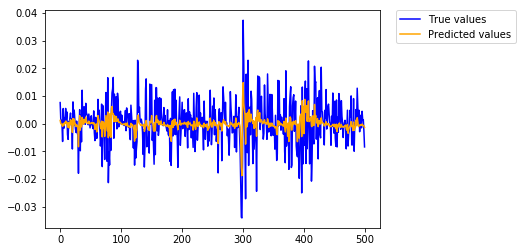

Epoch 1/1
 - 0s - loss: 0.0105


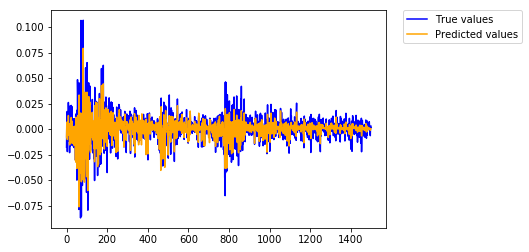

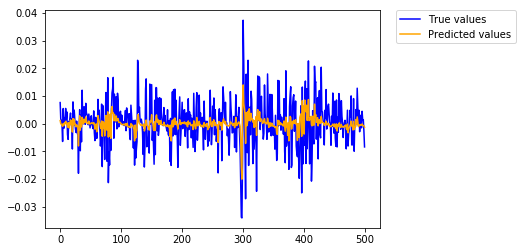

Epoch 1/1
 - 0s - loss: 0.0107


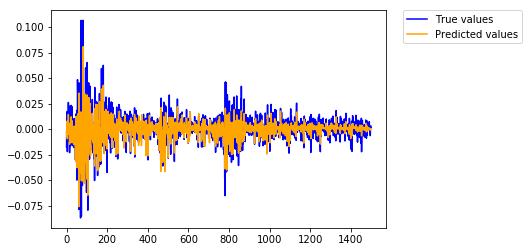

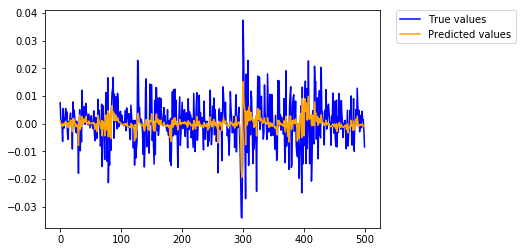

Epoch 1/1
 - 0s - loss: 0.0110


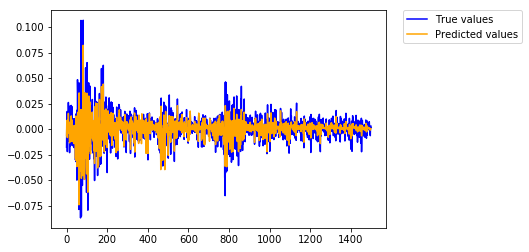

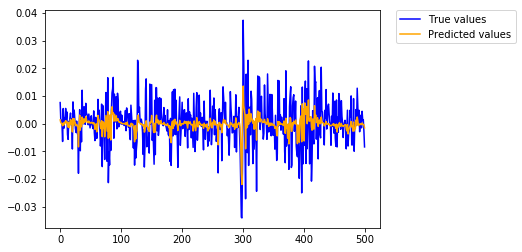

Epoch 1/1
 - 0s - loss: 0.0111


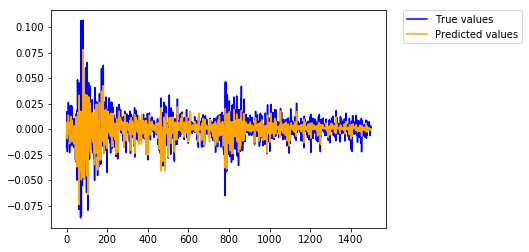

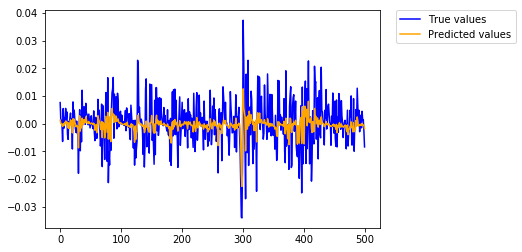

Epoch 1/1
 - 0s - loss: 0.0085


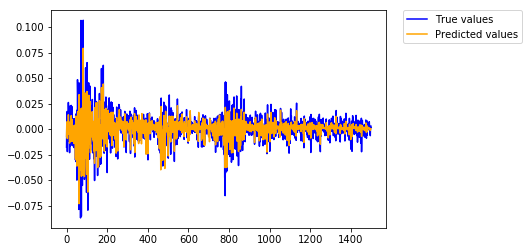

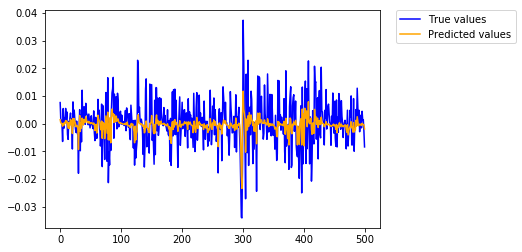

0) TrainScore=0.000054, TestScore=0.000045


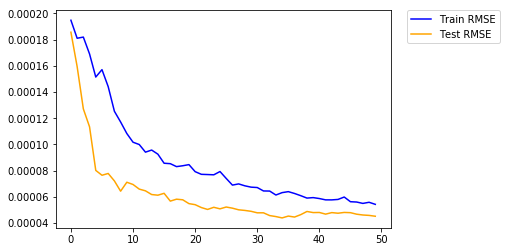

In [58]:
scores_n, pred, exp = run_index_scaled(2, 1, 10, 50, 4, 1500, 0, 2000, 1500)

In [35]:
scores_n, pred, exp = run_index_scaled(2, 2, 10, 50, 4, 1500, 0, 2000, 1500)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
scores_n, pred, exp = run_index_scaled(2, 1, 10, 200, 4, 1500, 0, 2000, 1500)

In [ ]:
scores_n, pred, exp = run_index_scaled(2, 1, 10, 200, 4, 1500, 0, 2000, 1500)

In [ ]:
scores_n, pred, exp = run_index_scaled(3, 1, 10, 200, 4, 1500, 0, 2000, 1500)

In [ ]:
data3.shape

In [ ]:
plt.plot(data3['Returns'])
plt.show()

In [ ]:
scores_n, pred, exp = run_index_scaled(3, 1, 10, 200, 4, 1500, 250, 2000, 1500)

In [ ]:
scores_n, pred, exp = run_index_scaled(3, 1, 10, 200, 4, 1500, 250, 1700, 1500)